<a href="https://colab.research.google.com/github/jsjang00/Pytorch/blob/main/VGGNet_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

trainset = datasets.CIFAR10(root="./data/", train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testset  = datasets.CIFAR10(root="./data/", train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

#classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class VGG(nn.Module):
    def __init__(self, base_dim, num_classes=10):
        super(VGG, self).__init__()
        self.feature = nn.Sequential(
            conv_2_block(3,base_dim), #64
            conv_2_block(base_dim,2*base_dim), #128
            conv_3_block(2*base_dim,4*base_dim), #256
            conv_3_block(4*base_dim,8*base_dim), #512
            conv_3_block(8*base_dim,8*base_dim), #512        
        )
        self.classifier = nn.Sequential(
            # CIFAR10은 크기가 32x32이므로 
            nn.Linear(8*base_dim*1*1, 4096), # 8*base_dim은 512이다. torchsummary를 통해 확인함
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.shape[0],-1)
        x = self.classifier(x)
        return x

In [ ]:
def conv_2_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [ ]:
def conv_3_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [ ]:
learning_rate = 0.0002

In [ ]:
model = VGG(base_dim=64).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from torchsummary import summary
summary(model, input_size = (3,32,32))

In [ ]:
loss_arr = []
n = len(trainloader) #배치 개수 

for epoch in range(10):
    running_loss = 0.0
    running_corrects = 0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)#배치 데이터 
        x = inputs.to(device)
        labels= labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs).to(device)
        loss = criterion(outputs,labels)
        _ , preds = torch.max(outputs,1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
    loss_arr.append(running_loss / n)
    print('[%d] loss: %.3f' %(epoch +1, running_loss / len(trainloader)))

[1] loss: 1.926
[2] loss: 1.572
[3] loss: 1.220
[4] loss: 0.981
[5] loss: 0.808
[6] loss: 0.682
[7] loss: 0.577
[8] loss: 0.494
[9] loss: 0.415
[10] loss: 0.352


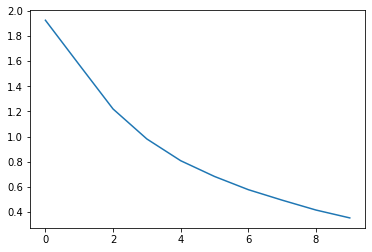

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_arr)
plt.show()

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0) # 개수 누적(총 개수)
        correct += (predicted == labels).sum().item() # 누적(맞으면 1, 틀리면 0으로 합산)
        
print(f'Test accuracy: {(100 * correct / total):.2f}%' )

Test accuracy: 79.59%
